<a href="https://colab.research.google.com/github/Saadman53/Thesis-Human-Activity-Recognition/blob/main/Alexnet_Classification(Sobel).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
gdrive_path = "drive/My Drive/Dataset/alexnet_extracted_sobel_4096(removed two layers).mat"
sensor_path = "drive/My Drive/Dataset/sensor_features_acc_gyro.mat"

Mounted at /content/drive


In [2]:
!pip install ax-platform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 KB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 KB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.optim as optim
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate


import torchvision
import torchvision.transforms as transforms



import random
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report


from torch.utils.data import DataLoader, ConcatDataset
# from torchvision import transforms
from sklearn.model_selection  import StratifiedKFold

import torch.optim.lr_scheduler as lr_scheduler
%matplotlib inline

import scipy.io as sio
torch.autograd.set_detect_anomaly(True)


from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn


In [5]:
dat = sio.loadmat(gdrive_path)

In [6]:
files = dat['filename'].ravel()
files = [x[0].replace(" ","") for x in files ]
map_filename_data = dict(zip(files, dat['data'].reshape(1165,4096)))
map_filename_label = dict(zip(files, dat['labels'].ravel()))
sensor_Dat = sio.loadmat(sensor_path)
train_files = sensor_Dat['train_filename'].ravel()
test_files = sensor_Dat['test_filename'].ravel()
valid_files =  sensor_Dat['valid_filename'].ravel()
train_X = []
train_y = []
test_X = []
test_y = []
val_X = []
val_y = []
for file in train_files:
  train_X.append(map_filename_data[file[0]])
  train_y.append(map_filename_label[file[0]])

for file in test_files:
  test_X.append(map_filename_data[file[0]])
  test_y.append(map_filename_label[file[0]])

for file in valid_files:
  val_X.append(map_filename_data[file[0]])
  val_y.append(map_filename_label[file[0]])

X_train = np.array(train_X)
X_test = np.array(test_X)
y_train = np.array(train_y)
y_test = np.array(test_y)
X_val = np.array(val_X)
y_val = np.array(val_y)
     

In [7]:
X_val.shape

(140, 4096)

In [8]:
alexnet_features = {'X_train':X_train, 'X_test': X_test, 'y_train': y_train, 'y_test':y_test, 'X_val':X_val, 'y_val': y_val}
sio.savemat("drive/My Drive/Dataset/alexnet_sobel_features.mat",alexnet_features)

In [9]:
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42, stratify = y)

In [10]:
class DNN(nn.Module):
    def __init__(self,input_size,output_size):
        super(DNN,self).__init__()
        self.hidden1 = nn.Linear(input_size,2048)
        self.hidden2 = nn.Linear(2048,1024)
        self.hidden3 = nn.Linear(1024,256)
        self.hidden4 = nn.Linear(256,64)
        self.output = nn.Linear(64,output_size)
        self.softmax = F.softmax
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.batchnorm1 = nn.BatchNorm1d(2048)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.batchnorm4 = nn.BatchNorm1d(64)
    
    def forward(self,x):
        out = self.hidden1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        
        out = self.hidden2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.hidden3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.hidden4(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.output(out)
        return out
     

In [11]:
def train_test_loader(X_train, X_test, y_train, y_test):
  scaler = StandardScaler()
  train_X = X_train
  test_X = X_test
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)
  train_dataset = TensorDataset(Tensor(train_X), Tensor(y_train))
  test_dataset = TensorDataset(Tensor(test_X), Tensor(y_test))
  test_loader = DataLoader(test_dataset, batch_size= 64)
  return train_dataset, test_loader

In [12]:
def net_train(net, train_loader, parameters):
  criterion = nn.CrossEntropyLoss(reduction = "sum")
  optimizer = optim.SGD(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9)
  )

  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=1.0,  # default is no learning rate decay
  )

  num_epochs = parameters.get("max_epoch", 3) # Play around with epoch number
  # Train Network
  for _ in range(num_epochs):
    for inputs, labels in train_loader:
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels.long())
      loss.backward()
      optimizer.step()
      scheduler.step()
  return net

In [13]:
def train_evaluate(parameterization):
    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(train_set,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=0,
                                pin_memory=True,drop_last=True)
    
    # Get neural net
    untrained_net = DNN(inpsize,outsize)
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization)
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=test_loader,
        dtype = torch.float,
        device = "cpu"
    )

In [14]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [16]:
train_set, test_loader = train_test_loader(X_train, X_val, y_train, y_val)
outsize = np.unique(y_train).shape[0]
inpsize = X_train.shape[1]

dtype = torch.float
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-3, 0.4], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [16, 128]},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},    
        {"name": "max_epoch", "type": "range", "bounds": [10, 100]},
        {"name": "stepsize", "type": "range", "bounds": [20, 40]},     
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 02-06 07:27:46] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-06 07:27:46] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batchsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-06 07:27:46] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-06 07:27:46] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_epoch. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter di

{'lr': 0.0028696462094477, 'batchsize': 74, 'momentum': 0.4320073220919612, 'max_epoch': 87, 'stepsize': 32}
{'accuracy': 0.9214285714285714}
{'accuracy': {'accuracy': nan}}


In [17]:
print(best_parameters)

{'lr': 0.0028696462094477, 'batchsize': 74, 'momentum': 0.4320073220919612, 'max_epoch': 87, 'stepsize': 32}


In [18]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])

best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

render(plot_contour(model=model, param_x='batchsize', param_y='lr', metric_name='accuracy'))

In [19]:
data = experiment.fetch_data()
dff = data.df
best_arm_name = dff.arm_name[dff['mean'] == dff['mean'].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

Arm(name='14_0', parameters={'lr': 0.0028696462094477, 'batchsize': 74, 'momentum': 0.4320073220919612, 'max_epoch': 87, 'stepsize': 32})

In [ ]:
# best_parameters = best_arm.parameters

In [20]:
def optim_scheduler(net,parameters):
  optimizer = optim.SGD(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9)
  )
  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=1.0,  # default is no learning rate decay
  )
  return optimizer, scheduler
def extract_batch(X,y,batch_size,step,no_of_samples):
  l = (step-1)*batch_size
  return X[l:(l+batch_size)],y[l:min(no_of_samples,l+batch_size)]

def model_training_evaluation(X_train, X_test, y_train, y_test):
  train_X = X_train
  test_X = X_test
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)
  train_X = torch.from_numpy(train_X.astype(np.float32))
  test_X = torch.from_numpy(test_X.astype(np.float32))
  train_y =  torch.tensor(y_train.astype(np.float32))
  test_y =  torch.tensor(y_test.astype(np.float32))
  input_size = train_X.shape[1]
  output_size = torch.unique(train_y).shape[0]
  learning_rate = best_parameters['lr']
  num_epochs = best_parameters['max_epoch']
  n_samples = train_X.shape[0]
  criterion = nn.CrossEntropyLoss(reduction='sum')
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
  net = DNN(input_size, output_size)
  optimizer, scheduler = optim_scheduler(net,best_parameters)
  figure, ax = plt.subplots(5,figsize=(10,10))
  figure.tight_layout(pad=5.0)
  cnt = 1
  best_loss = 100000
  best_model = None
  best_epoch = None
  for train_index, val_index in skf.split(X_train, y_train):
    train_X_fold = train_X[train_index]
    train_y_fold = train_y[train_index]
    val_x_fold = train_X[val_index]
    val_y_fold = train_y[val_index]
    n_samples = train_X_fold.shape[0]
    batch_size = best_parameters['batchsize']
    train_loss = []
    val_loss = []
    print(f"Training for fold {cnt}")
    for epoch in range(num_epochs):
      step = 1
      while(batch_size*step<=n_samples):
        x,y =  extract_batch(train_X_fold,train_y_fold, batch_size, step, n_samples)
        # Forward Propagation
        y_predicted = net(x)
        loss = criterion(y_predicted,  torch.tensor(y, dtype=torch.long))
        # Backward propagation and update
        loss.backward()
        optimizer.step()
        scheduler.step()
        # Performing zero grad before new step
        optimizer.zero_grad()
        step = step+1
      t_loss = criterion( net(train_X_fold),  torch.tensor(train_y_fold, dtype=torch.long)).item()/train_X_fold.shape[0]
      v_loss = criterion( net(val_x_fold),  torch.tensor(val_y_fold, dtype=torch.long)).item()/val_x_fold.shape[0]
      train_loss.append(t_loss) 
      val_loss.append(v_loss)
      if(v_loss<best_loss):
        best_loss = v_loss
        best_model = net
        best_epoch = epoch
      print(epoch*100/num_epochs)
    m = "Fold "+str(cnt)
    ax[cnt-1].title.set_text(m)
    ax[cnt-1].set_ylabel("Total Loss")
    ax[cnt-1].set_xlabel("No of Epochs")
    ax[cnt-1].plot(range(num_epochs),train_loss, label = "train loss")
    ax[cnt-1].plot(range(num_epochs),val_loss, label = "validation loss")
    cnt+=1
  y_pred = best_model(test_X)
  return best_model, y_pred


Training for fold 1
0.0
1.1494252873563218
2.2988505747126435
3.4482758620689653
4.597701149425287
5.747126436781609
6.896551724137931
8.045977011494253
9.195402298850574
10.344827586206897
11.494252873563218
12.64367816091954
13.793103448275861
14.942528735632184
16.091954022988507
17.24137931034483
18.39080459770115
19.54022988505747
20.689655172413794
21.839080459770116
22.988505747126435
24.137931034482758
25.28735632183908
26.436781609195403
27.586206896551722
28.735632183908045
29.885057471264368
31.03448275862069
32.18390804597701
33.333333333333336
34.48275862068966
35.632183908045974
36.7816091954023
37.93103448275862
39.08045977011494
40.229885057471265
41.37931034482759
42.52873563218391
43.67816091954023
44.827586206896555
45.97701149425287
47.12643678160919
48.275862068965516
49.42528735632184
50.57471264367816
51.724137931034484
52.87356321839081
54.02298850574713
55.172413793103445
56.32183908045977
57.47126436781609
58.62068965517241
59.770114942528735
60.91954022988506

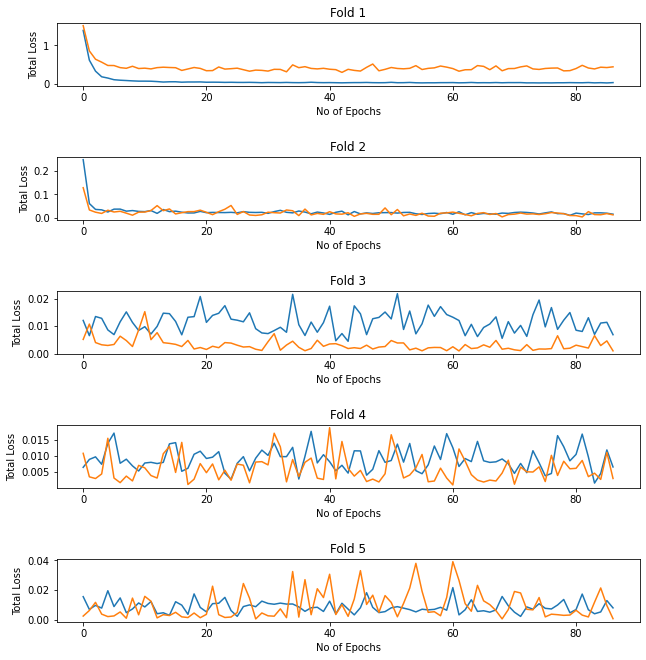

In [21]:
start = time.time()
model, y_pred = model_training_evaluation(X_train, X_test, y_train, y_test)
end = time.time()
training_time = end - start

In [22]:
print(f"Time took to train {training_time} seconds")

Time took to train 764.3538448810577 seconds


In [23]:
def cf_matrix(y_pred, test_y):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred = torch.max(y_pred_softmax, dim = 1)
  y_pred = y_pred.detach().numpy().ravel()
  correct_pred = (y_pred == test_y).astype(np.float)
  acc = correct_pred.sum()*100.0 / y_pred.shape[0]
  cm = confusion_matrix(test_y.ravel(), y_pred)
  recall = np.mean(recall_score(test_y.ravel(), y_pred, average=None))*100.0
  precision = np.mean(precision_score(test_y.ravel(), y_pred, average=None))*100.0
  f1 = 2*((precision*recall*1.0)/(precision+recall))
  f,ax=plt.subplots(figsize=(20,10))
  sns.heatmap(cm,annot=True,fmt='.0f', cmap="Blues")
  print(f"Accuracy: {acc:.2f}%")
  print(f"Precision: {precision:.2f}%")
  print(f"Recall: {recall:.2f}%")
  print(f"F1 score: {f1:.2f}%")
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()
  return cm,acc, recall, precision, f1


Accuracy: 90.56%
Precision: 90.84%
Recall: 90.41%
F1 score: 90.63%


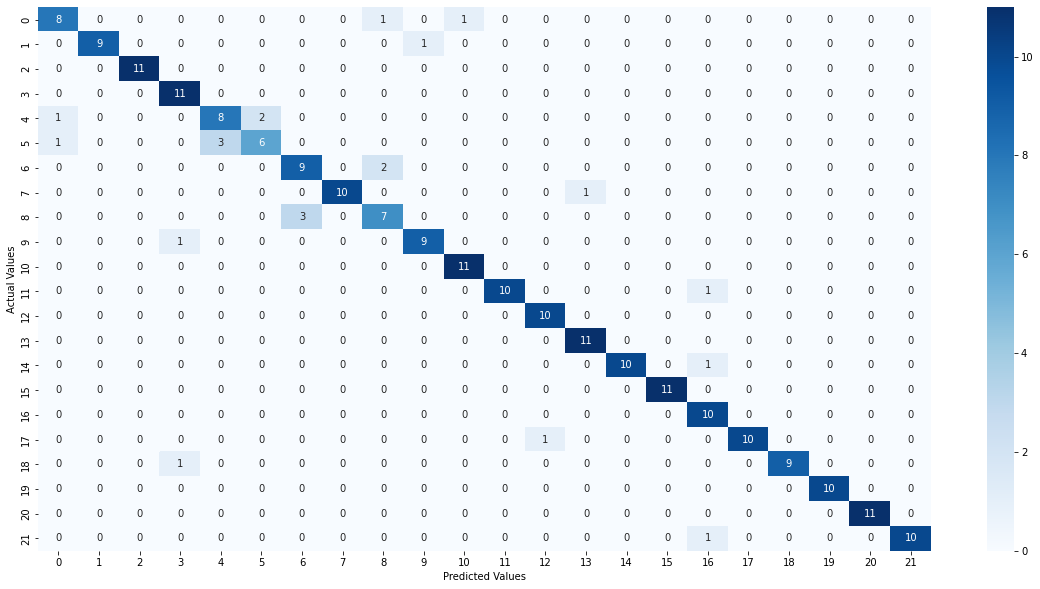

In [24]:
cm,acc, recall, precision,f1 = cf_matrix(y_pred, y_test)

In [25]:
pred_dict = {"preds":y_pred.detach().numpy(), 'y_test':y_test}
sio.savemat("drive/My Drive/Dataset/alexnet_sobel_predictions(optimized).mat", pred_dict)